In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy.stats import pearsonr
from scipy import sparse
import xarray as xr
import pandas as pd

from itertools import combinations

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import colorcet as cc

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

# March 2018

In [5]:
ice_ds_201803 = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201803.nc")

In [9]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile) 
        
codelengths_201803 = results['codelengths']
globalMixing_201803 = results['globalMixing']
globalCoherence_201803 = results['globalCoherence']
avg_mixing_201803 = results['avg_mixing']
avg_coherence_201803 = results['avg_coherence']
avg_boundary_201803 = results['avg_boundary']

In [10]:
qualityparametersDF_201803 = pd.DataFrame({"Codelength" : codelengths_201803,
                                           "Global Mixing" : globalMixing_201803,
                                           "Global Coherence" : globalCoherence_201803}, 
                                          )

In [11]:
qualityparametersDF_201803.corr()

Codelength  Global Mixing  Global Coherence
Codelength          1.000000      -0.460685          0.070669
Global Mixing      -0.460685       1.000000         -0.250830
Global Coherence    0.070669      -0.250830          1.000000

In [12]:
qualityparametersDF_201803.corr(method=lambda x, y: pearsonr(x, y)[1])

Codelength  Global Mixing  Global Coherence
Codelength          1.000000       0.000001          0.484752
Global Mixing       0.000001       1.000000          0.011831
Global Coherence    0.484752       0.011831          1.000000

In [69]:
qualityparametersDF_201803.mean()

Codelength          6.694415
Global Mixing       0.339275
Global Coherence    0.784372
dtype: float64

In [22]:
qualityparametersDF_201803.var()

Codelength          0.000142
Global Mixing       0.000005
Global Coherence    0.000045
dtype: float64

In [17]:
qualityparametersDF_201803.std()

Codelength          0.011915
Global Mixing       0.002275
Global Coherence    0.006679
dtype: float64

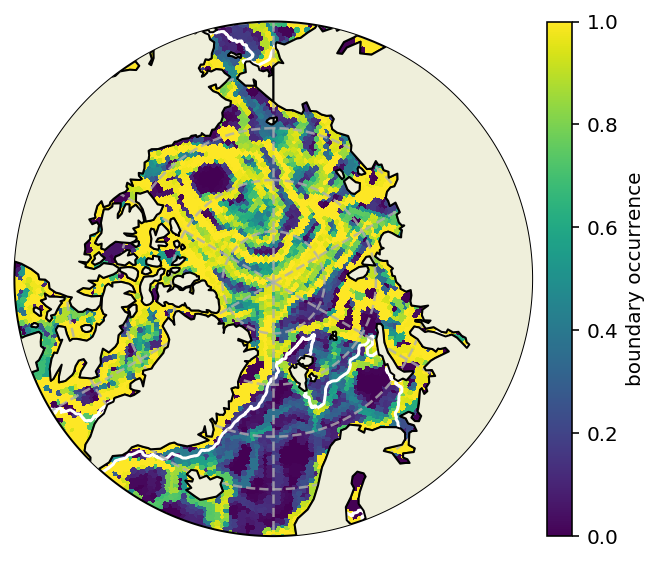

In [18]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2.png", dpi=300, bbox_inches='tight')

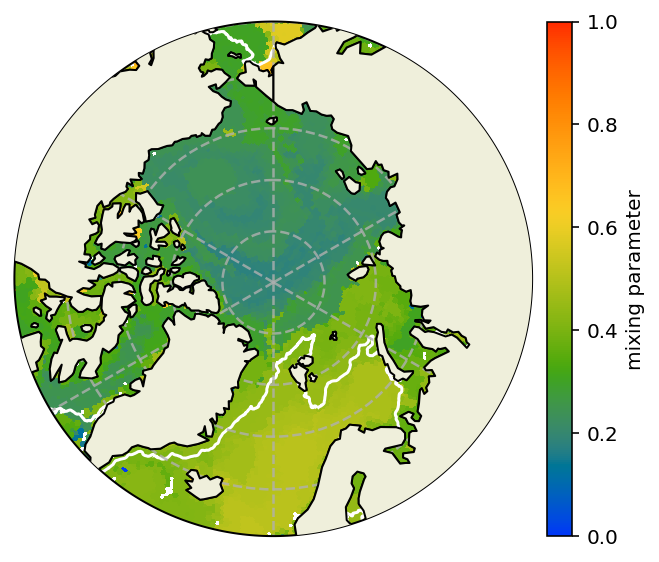

In [91]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_mixing_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2.png", dpi=300, bbox_inches='tight')

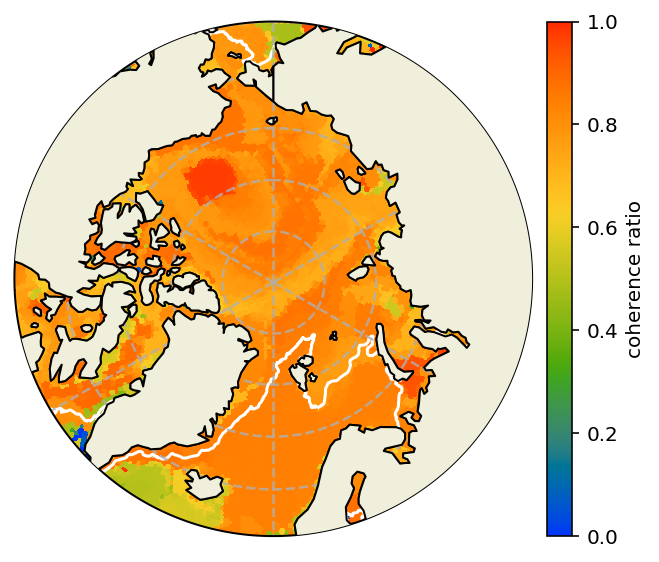

In [108]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_coherence_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2.png", dpi=300, bbox_inches='tight')

In [22]:
print("Indices of median codelength solutions:", np.argsort(qualityparametersDF_201803['Codelength'])[49],"and",np.argsort(qualityparametersDF_201803['Codelength'])[50])

Indices of median codelength solutions: 6 and 22


In [24]:
print("Solution 7")
print("Codelength: ", qualityparametersDF_201803['Codelength'][6])
print("Global Mixing: ", qualityparametersDF_201803['Global Mixing'][6])
print("Global Coherence: ", qualityparametersDF_201803['Global Coherence'][6])

Solution 7
Codelength:  6.69466
Global Mixing:  0.340090759350695
Global Coherence:  0.7830838343591949


In [25]:
print("Solution 23")
print("Codelength: ", qualityparametersDF_201803['Codelength'][22])
print("Global Mixing: ", qualityparametersDF_201803['Global Mixing'][22])
print("Global Coherence: ", qualityparametersDF_201803['Global Coherence'][22])

Solution 23
Codelength:  6.69478
Global Mixing:  0.3345715338500305
Global Coherence:  0.7934476013612213


Text(0.5, 0, 'Codelength')

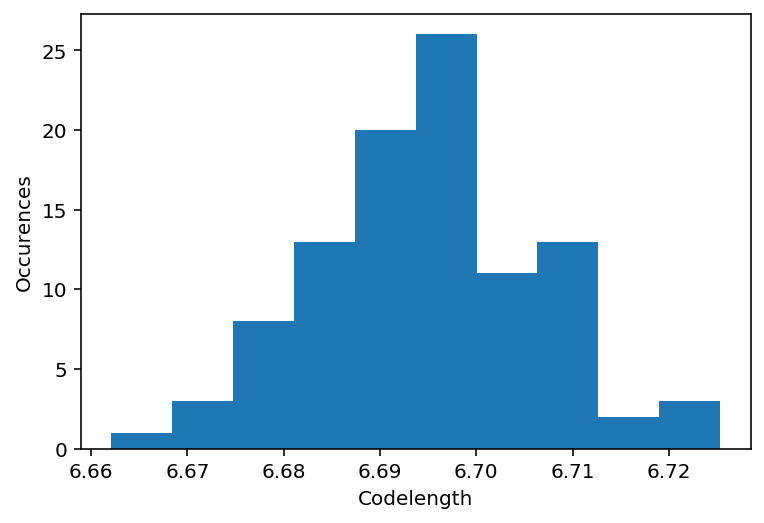

In [75]:
plt.hist(qualityparametersDF_201803['Codelength'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Codelength")

Text(0.5, 0, 'Global Mixing')

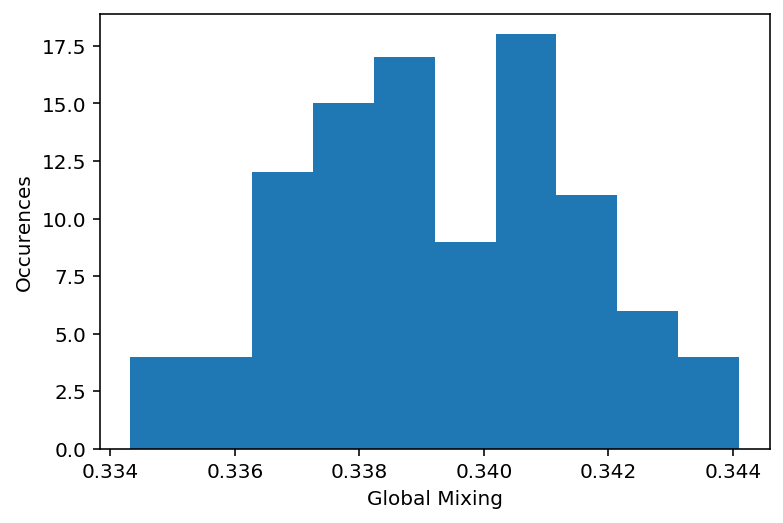

In [76]:
plt.hist(qualityparametersDF_201803['Global Mixing'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Global Mixing")

Text(0.5, 0, 'Global Coherence')

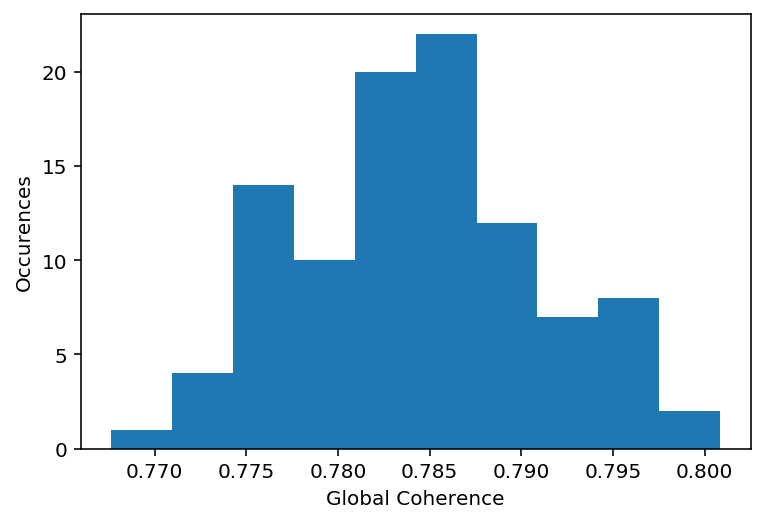

In [77]:
plt.hist(qualityparametersDF_201803['Global Coherence'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Global Coherence")

In [78]:
comName = f'masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_Cico7_mt2_multirunN7'

In [79]:
myBins.load_communities(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2/{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7830838343591949
Global Mixing Parameter 0.340090759350695


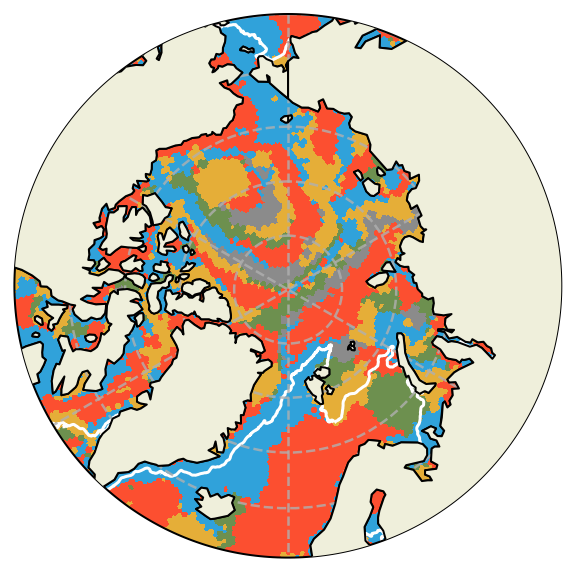

In [81]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

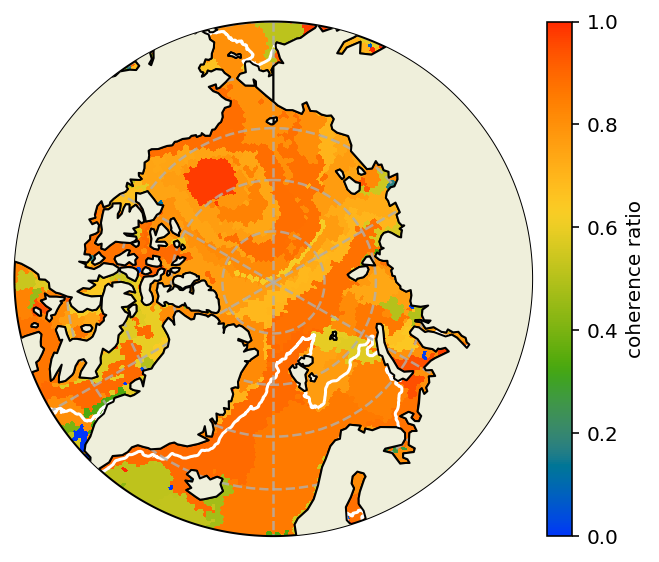

In [82]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/coherence_{comName}.png", dpi=300, bbox_inches='tight')

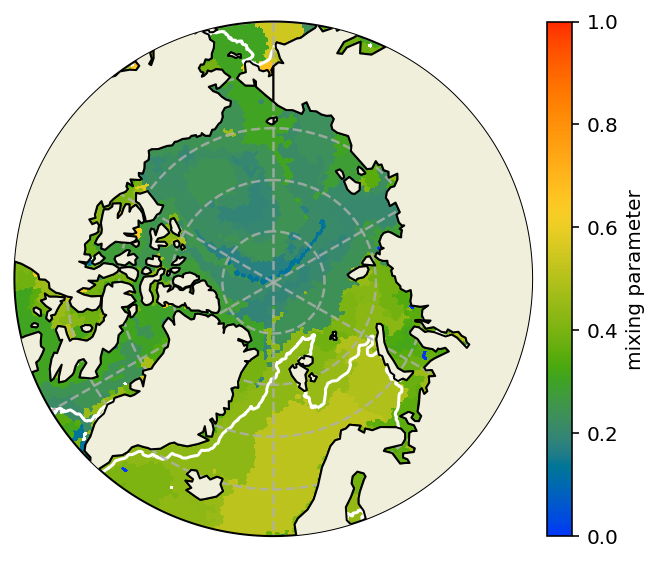

In [83]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/mixing_{comName}.png", dpi=300, bbox_inches='tight')

In [84]:
comName = f'masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_Cico7_mt2_multirunN23'

In [85]:
myBins.load_communities(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2/{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7934476013612213
Global Mixing Parameter 0.3345715338500305


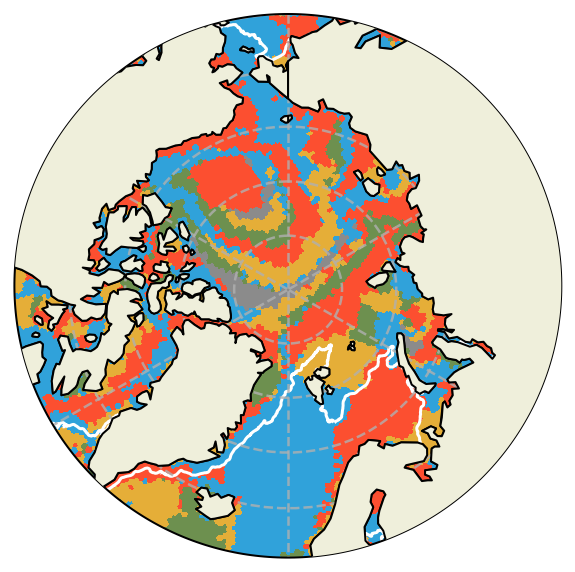

In [87]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

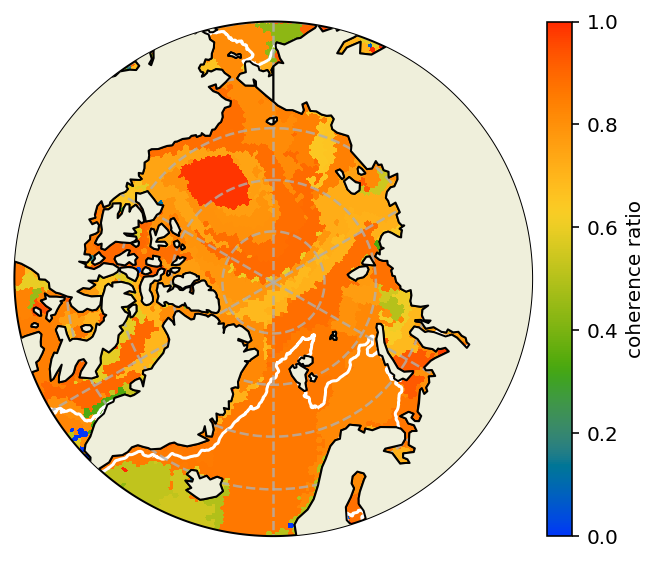

In [88]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/coherence_{comName}.png", dpi=300, bbox_inches='tight')

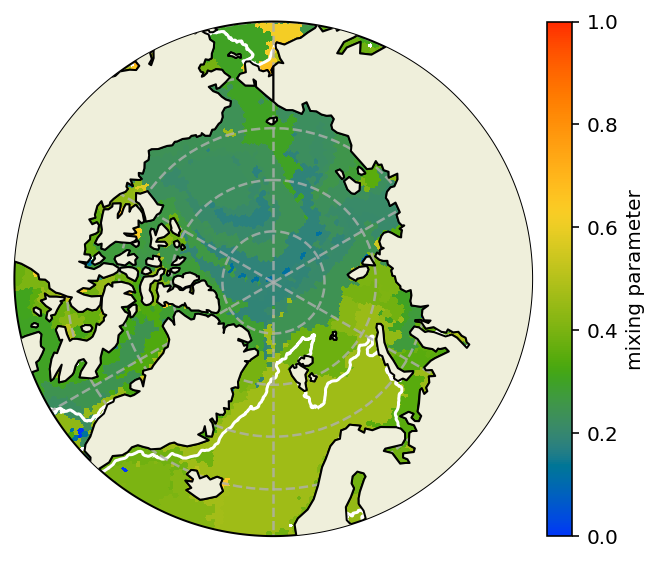

In [89]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/mixing_{comName}.png", dpi=300, bbox_inches='tight')

# Jaccard Distances

In [10]:
# Find bindex to test for:
myBins.pointToIdx(-19.3, 70.9)

array([11312])

In [78]:
intersection = np.logical_and(ensembleCommunityID[1] == ensembleCommunityID[1][11312], ensembleCommunityID[2] == ensembleCommunityID[2][11312])
union = np.logical_or(ensembleCommunityID[1] == ensembleCommunityID[1][11312], ensembleCommunityID[2] == ensembleCommunityID[2][11312])
print("Intersection:", np.sum(intersection))
print("Union:", np.sum(union))

Intersection: 332
Union: 649


In [80]:
print("Jaccard distance",  np.sum(intersection)/np.sum(union))

Jaccard distance 0.5115562403697997


In [45]:
intersection.astype('int')

masked_array(data=[0, --, 0, ..., 1, 0, 0],
             mask=[False,  True, False, ..., False, False, False],
       fill_value=1)

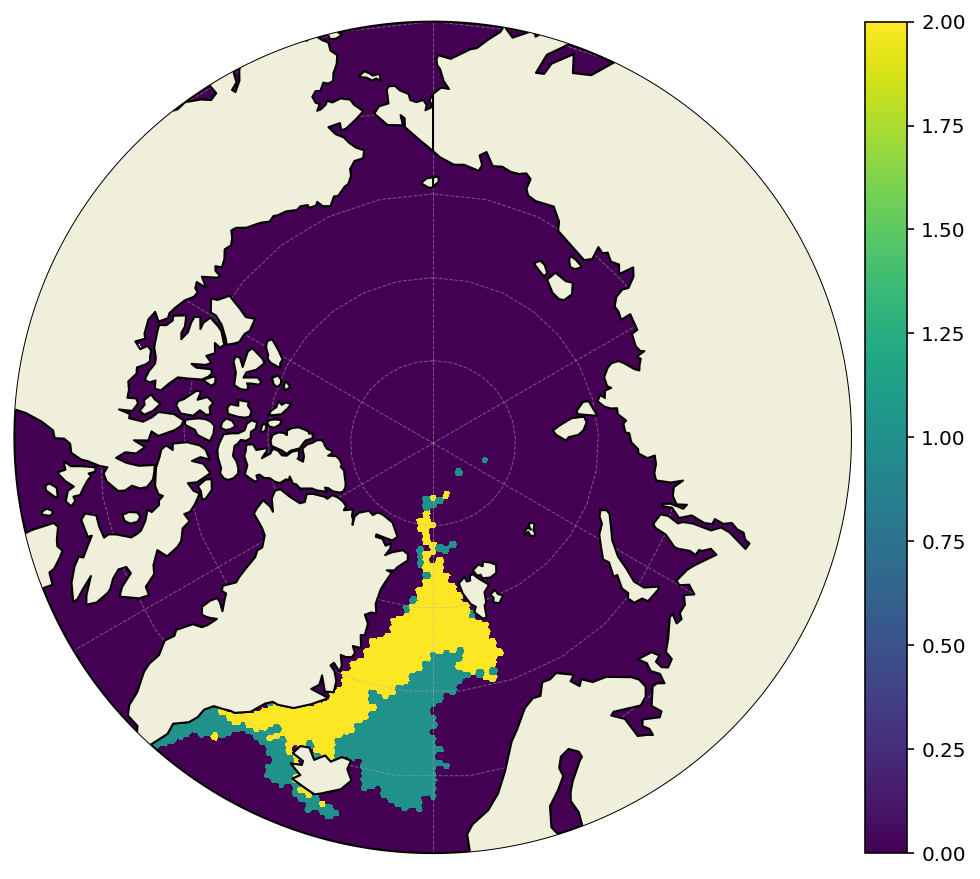

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             (intersection.astype('int')+union.astype('int'))[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             cbar = False,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 2,
                                            )

In [56]:
jaccardDistances = {}
for idx in myBins.bindex[myBins.oceanMask]:
    jaccarDistances[idx] = []
    for combo in combinations(ensembleCommunityID.keys(), 2):
        intersection = np.logical_and(ensembleCommunityID[combo[0]] == ensembleCommunityID[combo[0]][idx], ensembleCommunityID[combo[1]] == ensembleCommunityID[combo[1]][idx])
        union = np.logical_or(ensembleCommunityID[combo[0]] == ensembleCommunityID[combo[0]][idx], ensembleCommunityID[combo[1]] == ensembleCommunityID[combo[1]][idx])
        jaccardDistances[idx].append(np.sum(intersection)/np.sum(union))

4.26 s ± 60.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
with open("/data/oceanparcels/output_data/data_Daan/misc/jaccard_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100.pickle", "rb") as pickFile:
    jaccardDistances = pickle.load(pickFile)

In [9]:
jaccardDistancesMean = np.zeros(myBins.bindex.shape)
jaccardDistancesVariance = np.zeros(myBins.bindex.shape)
for k, v in jaccardDistances.items():
    jaccardDistancesMean[k] = np.array(v).mean()

(array([5.752e+03, 3.000e+00, 1.520e+02, 7.300e+02, 1.367e+03, 1.393e+03,
        1.052e+03, 7.250e+02, 5.310e+02, 6.610e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

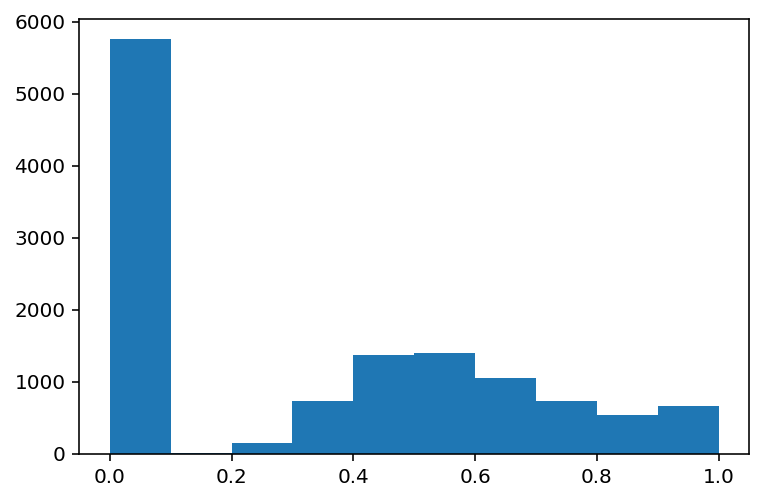

In [55]:
plt.hist(jaccardDistancesMean)

(array([746., 447., 273., 292., 704., 712., 835., 687., 224.,  30.]),
 array([0.02234637, 0.12011173, 0.21787709, 0.31564246, 0.41340782,
        0.51117318, 0.60893855, 0.70670391, 0.80446927, 0.90223464,
        1.        ]),
 <a list of 10 Patch objects>)

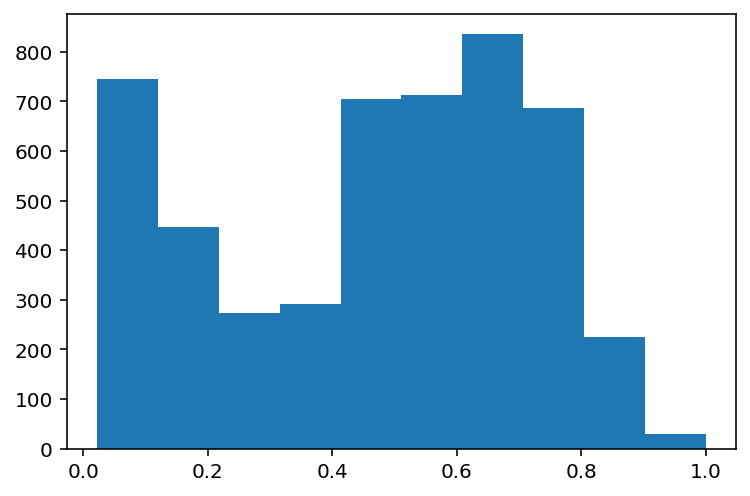

In [27]:
plt.hist(np.array(jaccardDistances[0]))

(array([   4.,   24.,   41.,   36.,   33.,  130.,  230.,  843., 2293.,
        1316.]),
 array([0.27777778, 0.35      , 0.42222222, 0.49444444, 0.56666667,
        0.63888889, 0.71111111, 0.78333333, 0.85555556, 0.92777778,
        1.        ]),
 <a list of 10 Patch objects>)

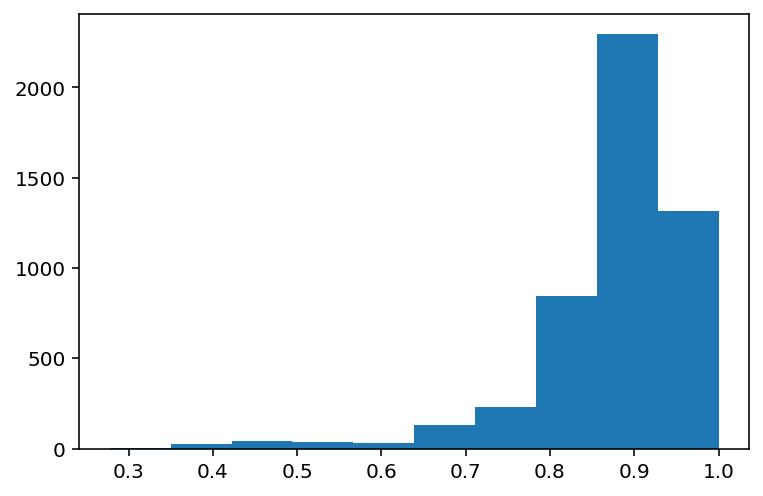

In [28]:
plt.hist(np.array(jaccardDistances[4]))

In [29]:
# Find bindex to test for:
myBins.pointToIdx(3, 75)

array([1898])

(array([873., 589., 561., 422., 507., 529., 591., 486., 280., 112.]),
 array([0.00781929, 0.10646375, 0.2051082 , 0.30375266, 0.40239712,
        0.50104157, 0.59968603, 0.69833049, 0.79697495, 0.8956194 ,
        0.99426386]),
 <a list of 10 Patch objects>)

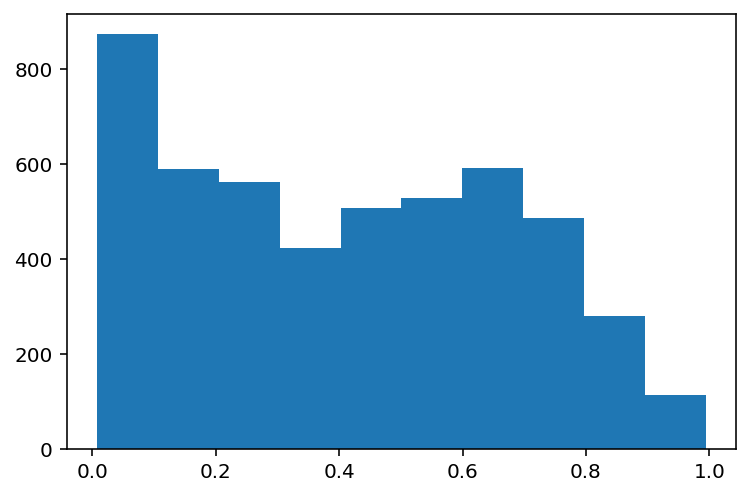

In [30]:
plt.hist(np.array(jaccardDistances[1898]))

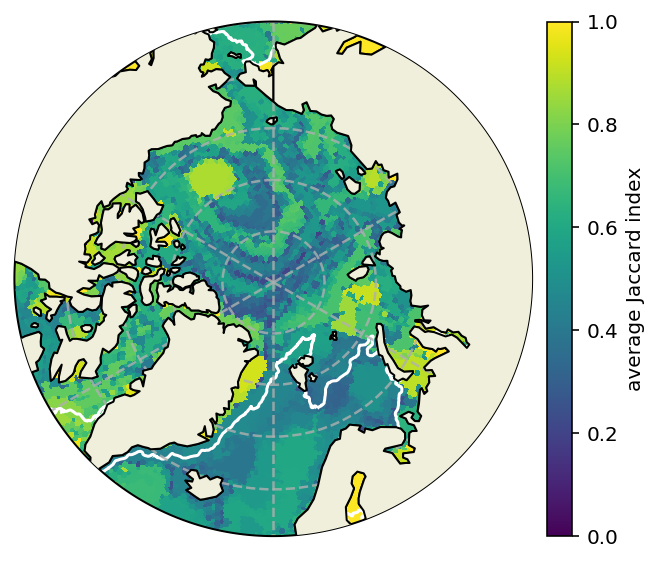

In [12]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             jaccardDistancesMean[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             units = "average Jaccard index",
                                             size=(5,5))
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_Jaccard_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2.png", dpi=300, bbox_inches='tight')

In [72]:
%%time
nSolutionClusters = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
combos = list(combinations(list(range(0,100)), 2))
clSorter = np.argsort(codelengths)

tolerance = 0.25

for idx in myBins.bindex[myBins.oceanMask]:
    localJaccardDistances = jaccardDistances[idx].copy()
    sortedIdx = clSorter.tolist()
    clustered = []
    nClusters = 0
    while len(sortedIdx) > 0 and len(clustered) <= 95:
        clusterCenter = sortedIdx.pop(0)
        clustered.append(clusterCenter)
        nClusters += 1
        for unclustered in sortedIdx:
            if unclustered < clusterCenter:
                pair = (unclustered, clusterCenter)
            else:
                pair = (clusterCenter, unclustered)
            pairIdx = combos.index(pair)
            if jaccardDistances[idx][pairIdx] > 1 - tolerance:
                clustered.append(sortedIdx.pop(sortedIdx.index(unclustered)))
    nSolutionClusters[idx] = nClusters

CPU times: user 338 ms, sys: 2.04 ms, total: 340 ms
Wall time: 336 ms


In [73]:
nSolutionClusters

masked_array(data=[35.0, --, 7.0, ..., 0.0, 0.0, 0.0],
             mask=[False,  True, False, ..., False, False, False],
       fill_value=1e+20)

In [74]:
with open("/data/oceanparcels/output_data/data_Daan/misc/nclusters_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100_threshold_0.25_95percent.pickle", "rb") as pickFile:
    nSolutionClusters = pickle.load(pickFile)

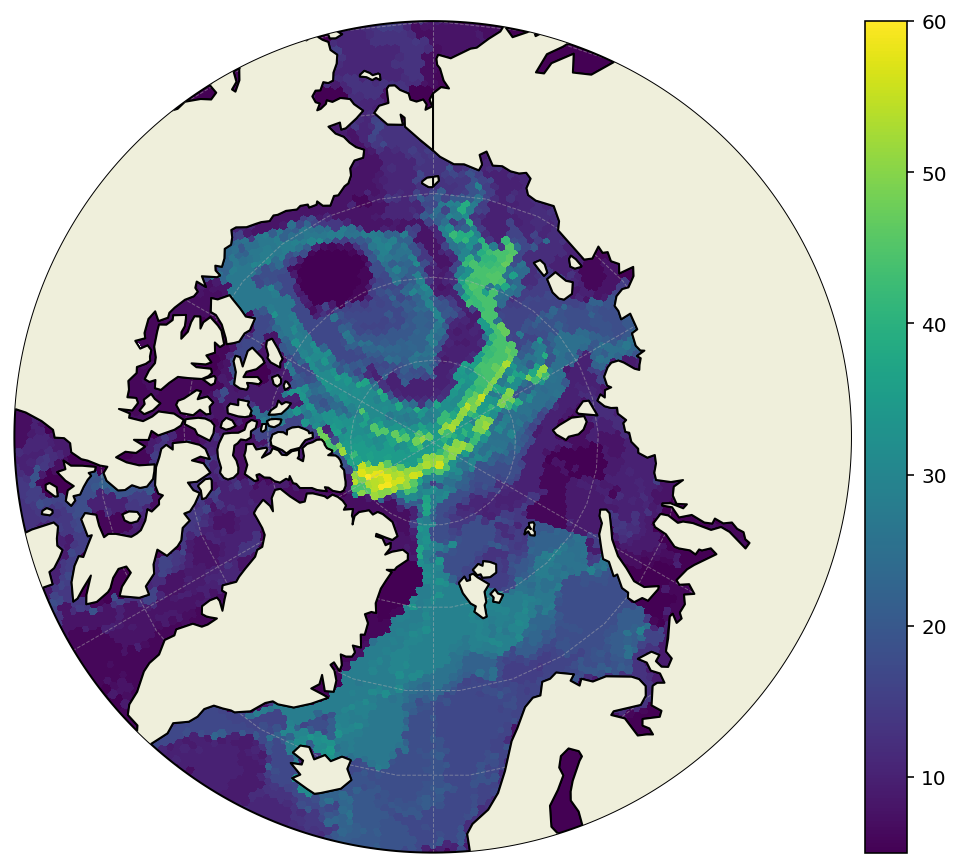

In [75]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             nSolutionClusters[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size = (5,5),
                                             units = "number of clusters")

In [81]:
poorJaccard = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for k, v in jaccardDistances.items():
    poorJaccard[k] = np.sum(np.array(v) < 0.2)/len(v)

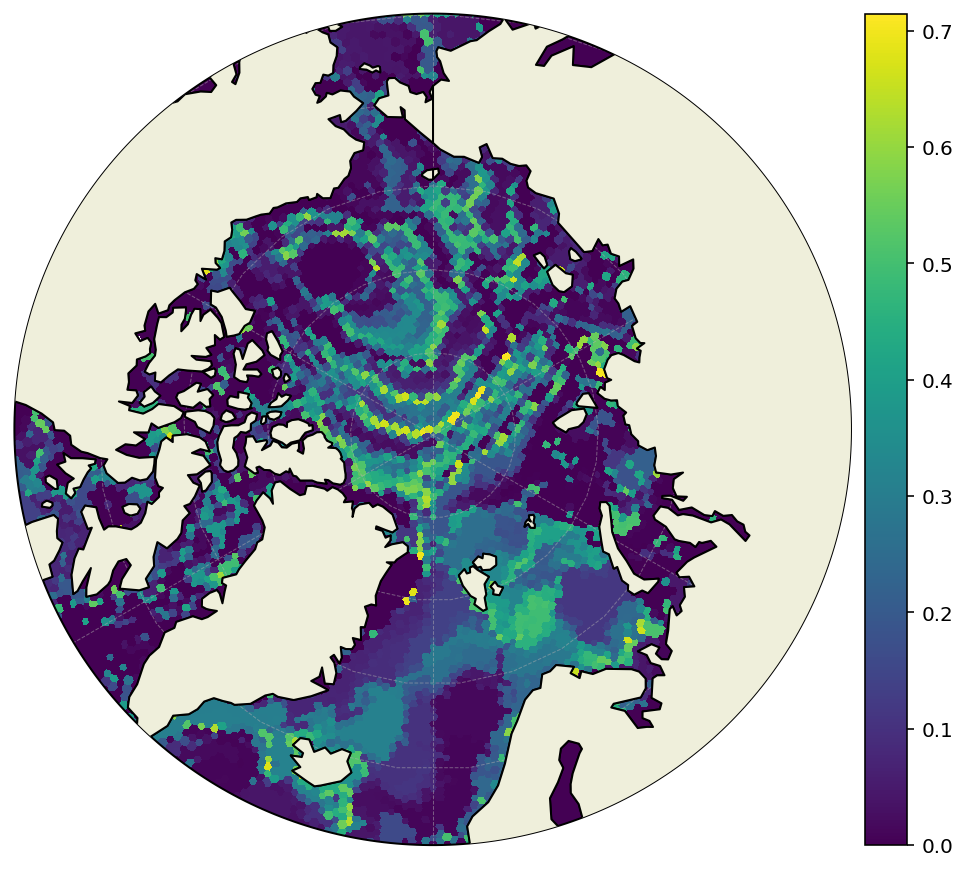

In [82]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             poorJaccard[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = True,
                                             size=(5,5), 
                                             units = "Percentage of Jaccard distance pairs lower than 0.2")

## Co-occurrence

In [8]:
from scipy import sparse, linalg

In [15]:
with open("/data/oceanparcels/output_data/data_Daan/misc/cooccurrence_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100.pickle", "rb") as pickFile:
    cooccurrence = pickle.load(pickFile)/100

### Checking n-connected sets

In [83]:
G_anyCooccurrence = nx.from_numpy_matrix(cooccurrence>0)
anyCooccurrenceComponents = nx.connected_component_subgraphs(G_anyCooccurrence)
anyCooccurrenceComponentsDict = {idx: comp.nodes() for idx, comp in enumerate(anyCooccurrenceComponents)}

In [89]:
connectedSet = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for comp, nodes in anyCooccurrenceComponentsDict.items():
    for node in list(nodes):
        connectedSet[myBins.bindex[myBins.oceanMask][node]] = comp
myBins.communityID = connectedSet
myBins.find_adjacency();
connectedSetColors = myBins.color_communities();

In [99]:
G_strongCooccurrence = nx.from_numpy_matrix(cooccurrence>0.95)
strongCooccurrenceComponents = nx.connected_component_subgraphs(G_strongCooccurrence)
strongCooccurrenceComponentsDict = {idx: comp.nodes() for idx, comp in enumerate(strongCooccurrenceComponents)}

In [100]:
stronglyConnectedSet = np.ma.masked_array(np.zeros(myBins.bindex.shape), ~myBins.oceanMask)
for comp, nodes in strongCooccurrenceComponentsDict.items():
    for node in list(nodes):
        stronglyConnectedSet[myBins.bindex[myBins.oceanMask][node]] = comp
myBins.communityID = stronglyConnectedSet
myBins.find_adjacency();
stronglyConnectedSetColors = myBins.color_communities();

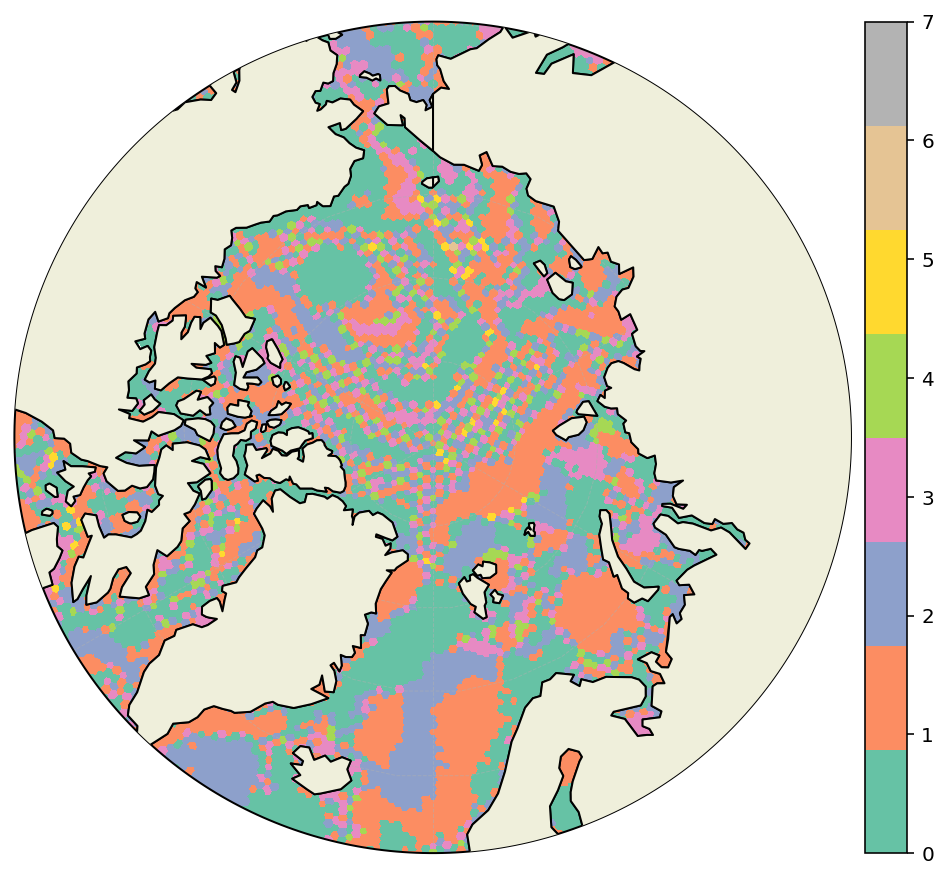

In [101]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             stronglyConnectedSetColors[myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             polar = True,
                                             land = True,
                                             cbar = False,
                                             size=(5,5))

In [91]:
myBins.pointToIdx(5, 67)

array([6159])

In [92]:
myBins.pointToIdx(-17, 68)

array([3463])

In [93]:
stronglyConnectedSet[6159]

5.0

In [94]:
stronglyConnectedSet[3463]

5.0

### Sparsity

In [11]:
np.sum(cooccurrence == 0)/(cooccurrence.shape[0]*cooccurrence.shape[1])

0.9158743550919516

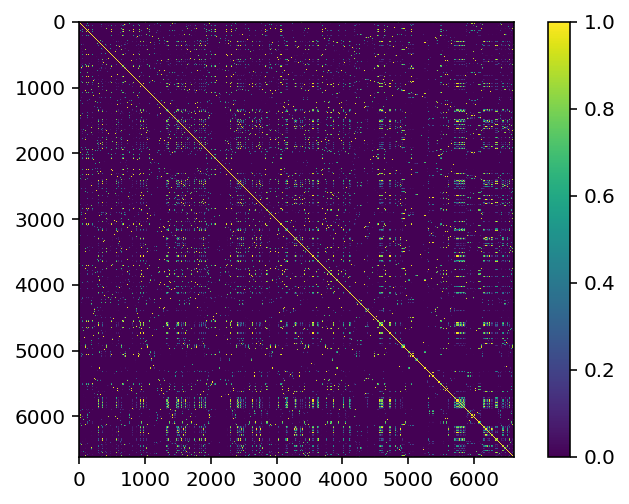

In [52]:
plt.imshow(cooccurrence)
plt.colorbar()

In [13]:
D = np.diag(np.sum(cooccurrence, axis=1))
L = D - cooccurrence

In [14]:
la, v = linalg.eig(L)

In [19]:
v.shape

(6614, 6614)

In [23]:
sortr = np.argsort(la)

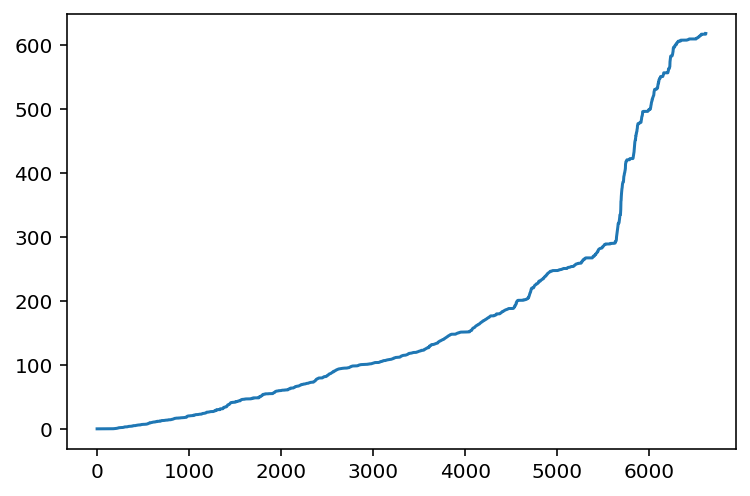

In [25]:
plt.plot(la[sortr])

In [28]:
v[:, sortr][:, 0]

array([-0.00014429+0.j, -0.00014429+0.j, -0.00014429+0.j, ...,
       -0.00014429+0.j, -0.00014429+0.j, -0.00014429+0.j])

### Nested

In [42]:
G = nx.from_numpy_matrix(cooccurrence)
nx.write_pajek(G, "data/oceanparcels/output_data/data_Daan/misc/graph_of_cooccurrence_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100")

In [48]:
myBins.load_communities("/data/oceanparcels/output_data/data_Daan/misc/comm_of_graph_of_cooccurrence_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble100.clu.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();

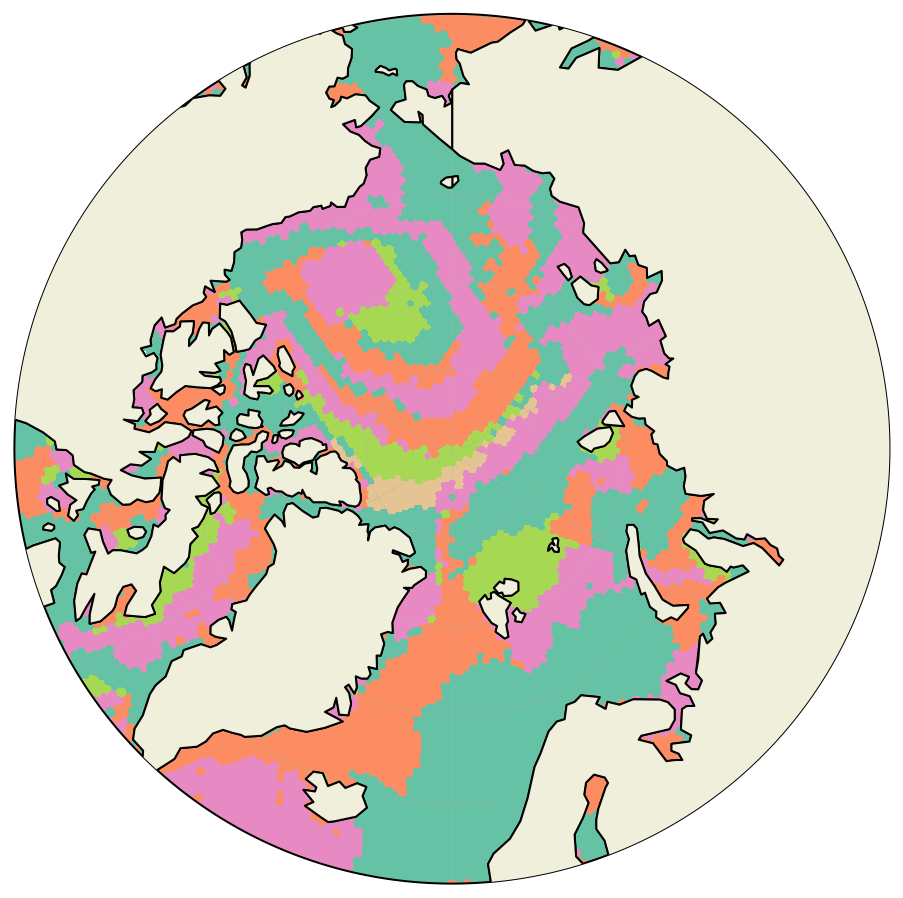

In [49]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             land = True,
                                             cbar = False,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size=(5,5))

# 30 days

In [13]:
transMat_201803_subD30 = community.transMat.from_counter_npz(matdir + f"masked_counter_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_subD30.npz")

In [14]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_subD30_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile) 
        
codelengths_201803_subD30 = results['codelengths']
globalMixing_201803_subD30 = results['globalMixing']
globalCoherence_201803_subD30 = results['globalCoherence']
avg_mixing_201803_subD30 = results['avg_mixing']
avg_coherence_201803_subD30 = results['avg_coherence']
avg_boundary_201803_subD30 = results['avg_boundary']

In [15]:
qualityparametersDF_201803_subD30 = pd.DataFrame({"Codelength" : codelengths_201803_subD30,
                                    "Global Mixing" : globalMixing_201803_subD30,
                                    "Global Coherence" : globalCoherence_201803_subD30}, 
                                )

In [16]:
qualityparametersDF_201803_subD30.corr()

Codelength  Global Mixing  Global Coherence
Codelength          1.000000      -0.032809          0.024692
Global Mixing      -0.032809       1.000000         -0.617391
Global Coherence    0.024692      -0.617391          1.000000

In [17]:
qualityparametersDF_201803_subD30.mean()

Codelength          6.553600
Global Mixing       0.324159
Global Coherence    0.808378
dtype: float64

In [18]:
qualityparametersDF_201803_subD30.var()

Codelength          0.000031
Global Mixing       0.000002
Global Coherence    0.000011
dtype: float64

In [19]:
qualityparametersDF_201803_subD30.std()

Codelength          0.005566
Global Mixing       0.001336
Global Coherence    0.003388
dtype: float64

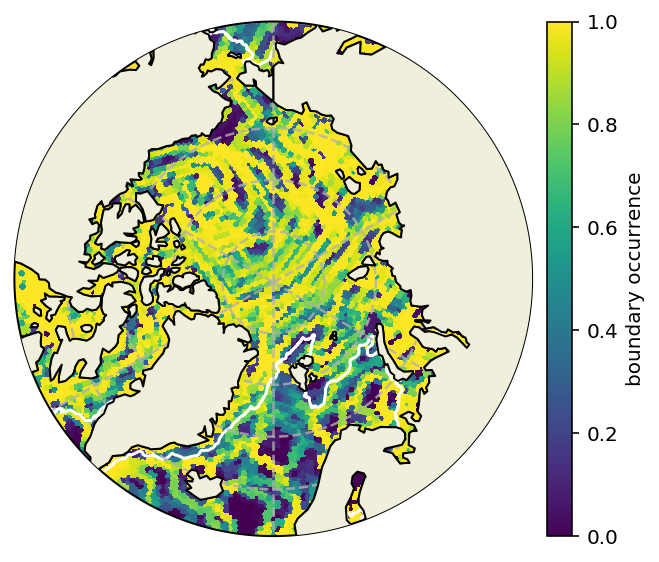

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201803_subD30[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico7_subD30_mt2.png", dpi=300, bbox_inches='tight')

# September 2018

In [21]:
ice_ds_201809 = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201809.nc")

## 90 days

In [29]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
    results = pickle.load(pickFile) 
        
codelengths_201809 = results['codelengths']
globalMixing_201809 = results['globalMixing']
globalCoherence_201809 = results['globalCoherence']
avg_mixing_201809 = results['avg_mixing']
avg_coherence_201809 = results['avg_coherence']
avg_boundary_201809 = results['avg_boundary']

In [30]:
qualityparametersDF_201809 = pd.DataFrame({"Codelength" : codelengths_201809,
                                    "Global Mixing" : globalMixing_201809,
                                    "Global Coherence" : globalCoherence_201809}, 
                                )

In [31]:
qualityparametersDF_201809.corr()

Codelength  Global Mixing  Global Coherence
Codelength           1.00000      -0.278600          0.254180
Global Mixing       -0.27860       1.000000         -0.442776
Global Coherence     0.25418      -0.442776          1.000000

In [32]:
qualityparametersDF_201809.mean()

Codelength          7.461861
Global Mixing       0.376538
Global Coherence    0.784269
dtype: float64

In [33]:
qualityparametersDF_201809.var()

Codelength          0.000155
Global Mixing       0.000006
Global Coherence    0.000028
dtype: float64

In [34]:
qualityparametersDF_201809.std()

Codelength          0.012446
Global Mixing       0.002531
Global Coherence    0.005291
dtype: float64

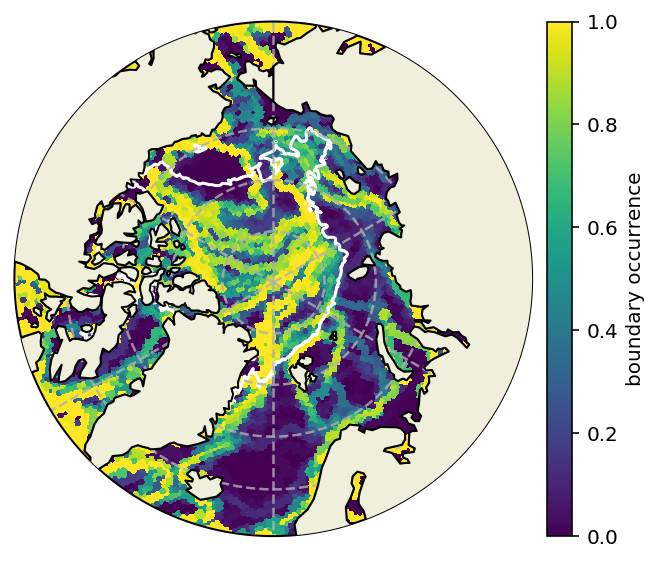

In [35]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             results['avg_boundary'][myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201809.longitude, ice_ds_201809.latitude[1680:], ice_ds_201809.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_mt2.png", dpi=300, bbox_inches='tight')

In [127]:
with open("average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", "wb") as pickFile:
    pickle.dump(avg_boundary_201809, pickFile)

In [ ]:
multiFiles = []
for month in ["09", "10", "11"]:
    multiFiles.append(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_2018{month}.nc")
ds_2018septoctnov = xr.open_mfdataset(multiFiles) 

In [ ]:
meanvelo_2018septoctnov = np.mean(np.sqrt(np.square(ds_2018septoctnov.uo[:, 0, 1680:, :]) + np.square(ds_2018septoctnov.vo[:, 0, 1680:, :])), axis=0).compute()

In [35]:
meansiconc_2018septoctnov = np.mean(ds_2018septoctnov.siconc[:, 1680:, :], axis=0)

In [36]:
meshlon, meshlat= np.meshgrid(ds_2018septoctnov.longitude, ds_2018septoctnov.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
veloVals = np.where(np.isnan(meanvelo_2018septoctnov.data.flatten()), 0, meanvelo_2018septoctnov.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedVelocity = griddata(dataPoints, veloVals, binPoints, method="nearest")

In [ ]:
meshlon, meshlat= np.meshgrid(ds_2018septoctnov.longitude, ds_2018septoctnov.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
iceVals = np.where(np.isnan(meansiconc_2018septoctnov.data.flatten()), 0, meansiconc_2018septoctnov.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedIce = griddata(dataPoints, iceVals, binPoints, method="nearest")

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


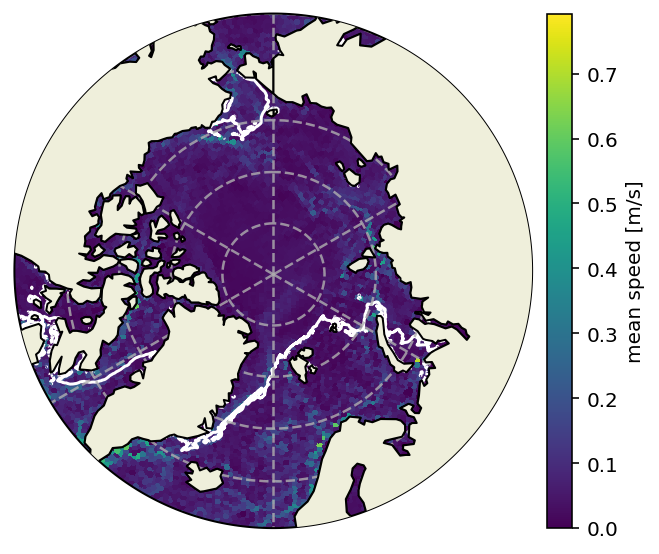

In [40]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedVelocity[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             cbar = True,
                                             polar = True,
#                                              title = r"Mean speed (SON 2009-2018)",
                                             units = "mean speed [m/s]"
                                            )
ax.contour(ds_2018septoctnov.longitude, ds_2018septoctnov.latitude[1680:], meansiconc_2018septoctnov, levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/mean_speed_2018septoctnov.png", dpi=300, bbox_inches='tight')

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


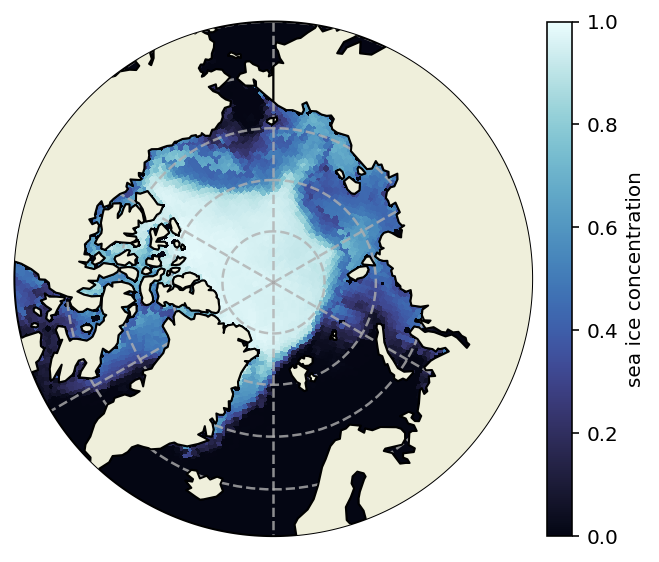

In [51]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedIce[myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cmocean.cm.ice,
                                            size = (5,5),
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            units = "sea ice concentration"
                                            )
# ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/mean_ice_2018septoctnov.png", dpi=300, bbox_inches='tight')

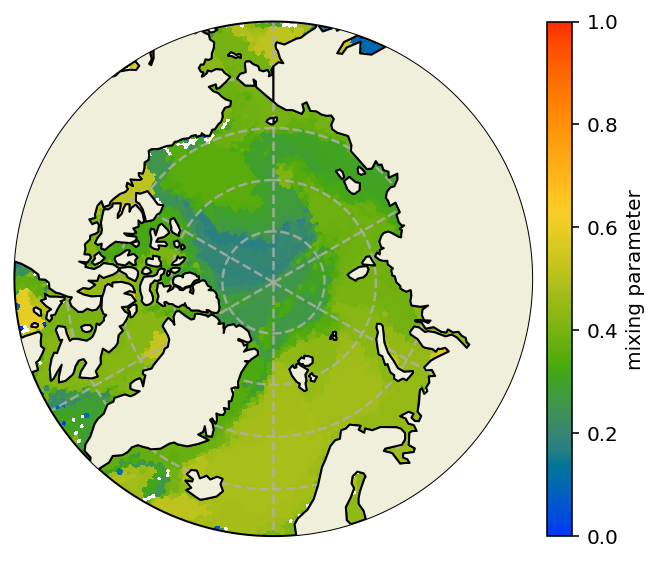

In [53]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_201809[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"average_mixing_201809.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )

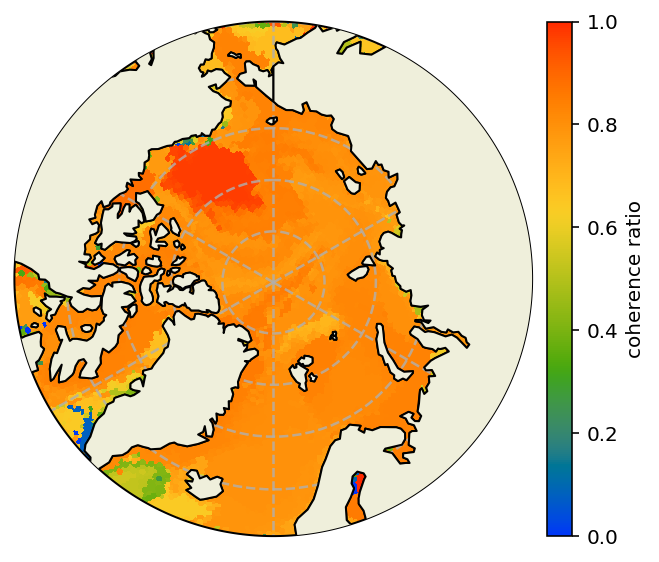

In [54]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_201809[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"average_coherence_201809.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )

In [48]:
icemask = (interpolatedIce < 0.15).compute()
pearsonr(interpolatedVelocity[np.logical_or(myBins.oceanMask, icemask)],
         avg_boundary_201809[np.logical_or(myBins.oceanMask, icemask)])

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.32778318211803786, 8.724184514252198e-307)

In [58]:
pearsonr(avg_coherence_201809, interpolatedIce)

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.5548236161805589, 0.0)

In [59]:
pearsonr(avg_mixing_201809, interpolatedIce)

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.06097906883315075, 1.1476211068752205e-11)

# 30 Days

In [36]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_subD30_mt2.pickle", 'rb') as pickFile:
    results = pickle.load(pickFile) 
        
codelengths_201809_subD30 = results['codelengths']
globalMixing_201809_subD30 = results['globalMixing']
globalCoherence_201809_subD30 = results['globalCoherence']
avg_mixing_201809_subD30 = results['avg_mixing']
avg_coherence_201809_subD30 = results['avg_coherence']
avg_boundary_201809_subD30 = results['avg_boundary']

In [37]:
qualityparametersDF_201809_subD30 = pd.DataFrame({"Codelength" : codelengths_201809_subD30,
                                    "Global Mixing" : globalMixing_201809_subD30,
                                    "Global Coherence" : globalCoherence_201809_subD30}, 
                                )

In [38]:
qualityparametersDF_201809_subD30.corr()

Codelength  Global Mixing  Global Coherence
Codelength          1.000000      -0.337936          0.083748
Global Mixing      -0.337936       1.000000         -0.704038
Global Coherence    0.083748      -0.704038          1.000000

In [41]:
qualityparametersDF_201809_subD30.mean()

Codelength          7.381429
Global Mixing       0.352168
Global Coherence    0.812692
dtype: float64

In [40]:
qualityparametersDF_201809_subD30.var()

Codelength          0.000073
Global Mixing       0.000003
Global Coherence    0.000017
dtype: float64

In [42]:
qualityparametersDF_201809_subD30.std()

Codelength          0.008543
Global Mixing       0.001835
Global Coherence    0.004077
dtype: float64

In [ ]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201809_subD30[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201809.longitude, ice_ds_201809.latitude[1680:], ice_ds_201809.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_subD30_mt2.png", dpi=300, bbox_inches='tight')